# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Цель исследования: 
         
1. Изучить воронку продаж. Узнать, как пользователи доходят до покупки. 
2. Выяснить, какой шрифт лучше. (Дизайнеры захотели поменять шрифты во всём приложении)

Ход исследования

Данные получу из файла /datasets/logs_exp.csv.
О качестве данных пока неизвестно. Поэтому перед тем как приступить к целям исследования, понадобиться обзор данных.
Проверю данные на пропуски, ошибки и выбивающиеся значения. Затем на этапе предобработке я исправлю все ошибки в данных, которые не приведут к искажению конечного результата. Далее создам необходимые столбцы для анализа данных. Добавлю столбец даты и времени, а также отдельный столбец дат. Затем приступлю к изучению данных, воронки событий и результатов эксперимента.

Таким образом, мое исследование будет состоять из следующих этапов:
1. Обзор данных
2. Предобработка данных
3. Изучение данных
4. Изучение воронки событий
5. Изучение результатов эксперимента
6. Проверка гипотез
7. Написание общего вывода

## Откроем файл с данными и изучим общую информацию


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn as sb
import math as mth
from scipy import stats as st

In [2]:
path = '/datasets/'
df = pd.read_csv(path + 'logs_exp.csv', sep='\t')
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовим данные

### Заменим названия столбцов на удобные

In [3]:
df.columns = ['event_name', 'device_id', 'datetime', 'experiment_id']

### Проверим пропуски и типы данных. Откорректируем при необходимости

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   device_id      244126 non-null  int64 
 2   datetime       244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df['device_id'] = df['device_id'].astype(str)
df['experiment_id'] = df['experiment_id'].astype(str)

Проверим датасет на дубликаты

In [6]:
df.duplicated().sum()

413

Удалим дубликаты

In [7]:
df = df.drop_duplicates()

Добавим столбец даты и времени, а также отдельный столбец дат

In [8]:
df['date'] = df['datetime'].dt.date

In [9]:
df.head(5)

,event_name,device_id,datetime,experiment_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Удалены дубликаты, откорректированы типы данных, добавлен столбец с датой. Пропуски в таблице отсутствуют.

##  Изучим и проверим данные

### Сколько всего событий в логе?

In [10]:
print('There are', len(df['event_name'].value_counts()), 'events in the log')

There are 5 events in the log


In [11]:
print('Total events in the log', len(df['event_name']))

Total events in the log 243713


In [12]:
#Let's look at the number of events of each type
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

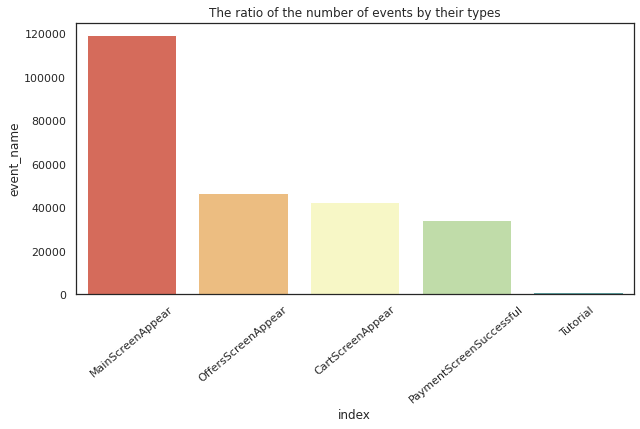

In [13]:
#visualize the table as bar charts
sns.set(style='white')
plt.figure(figsize=(10, 5))
plt.title('The ratio of the number of events by their types')
sns.barplot(x='index',y='event_name', data=df['event_name'].value_counts().reset_index(), palette='Spectral')
plt.xticks(rotation=40) 
plt.show()

В логе есть 5 событий, по убыванию их популярности: 
- показ пользователю главного экрана
- показ экрана с предложением
- показ экрана корзины
- показ экрана с подтверждением оплаты
- показ обучения 

### Сколько всего пользователей в логе?

In [14]:
print('There are', len(df['device_id'].value_counts()), 'users')

There are 7551 users


### Сколько в среднем событий приходится на пользователя?

In [15]:
df_events = df.pivot_table(index='device_id',values='event_name',aggfunc='count')
print('On average, per user', round(df_events['event_name'].mean(), 1), 'events')

On average, per user 32.3 events


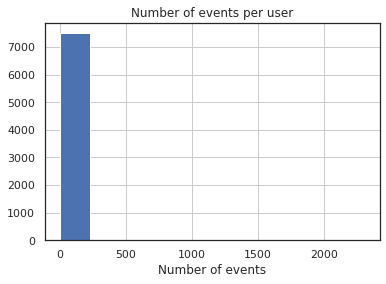

In [16]:
df_events['event_name'].hist().set_title('Number of events per user')
plt.xlabel('Number of events')
plt.show()

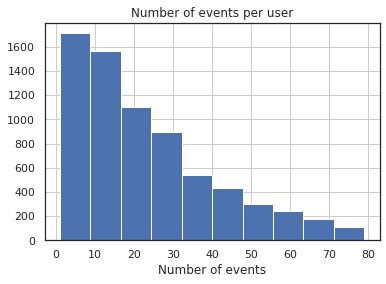

In [17]:
#Let's discard the emissions
df_events.query('event_name < 80')['event_name'].hist().set_title('Number of events per user')
plt.xlabel('Number of events')
plt.show()

В среднем на пользователя приходится 32 события. Но это число завышено из за больших выбросов. Чаще всего на пользователей приходится 1-30 событий.

### Данными за какой период мы располагаем? 
- Найти максимальную и минимальную дату. 
- Построить гистограмму по дате и времени. 
- Можно ли быть уверенным, что у вас одинаково полные данные за весь период? 
Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
- Определить, с какого момента данные полные и отбросьте более старые. 
- Данными за какой период времени мы располагаем на самом деле?

In [18]:
print('Min date', df['date'].min())
print('Max date', df['date'].max())

Min date 2019-07-25
Max date 2019-08-07


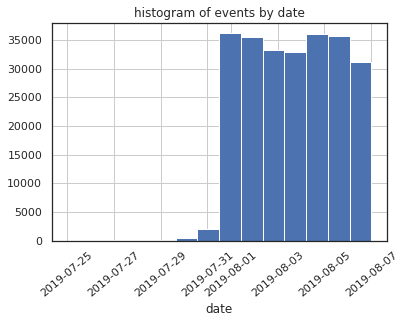

In [19]:
# histogram of events by date
df['date'].hist(bins = 14).set_title('histogram of events by date')
plt.xlabel('date')
plt.xticks(rotation=40) 
plt.show()

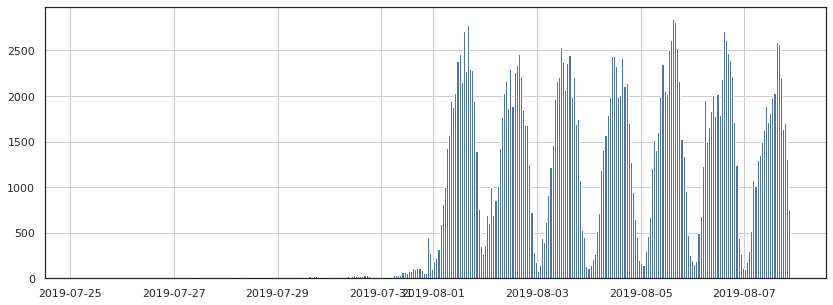

In [20]:
# код ревьюера
df['datetime'].hist(bins=14*24, figsize=(14, 5));

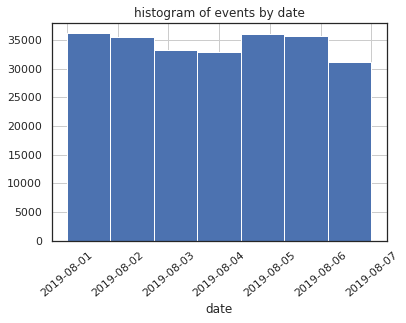

In [21]:
# histogram of events by date, starting from 07/31/2019
df['date'] = pd.to_datetime(df['date'])
df_new_data = df.query('date > "2019-07-31"')
df_new_data['date'].hist(bins = 7).set_title('histogram of events by date')
plt.xlabel('date')
plt.xticks(rotation=40) 
plt.show()

По гистограмме видно, что до 01.08.2019 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов.

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [22]:
event_name = len(df)
users = df['device_id'].nunique()

In [23]:
date_threshold = pd.to_datetime('2019-08-01', format = '%Y-%m-%d')
df = df[df['date'] >= date_threshold]

events_filtered = len(df)
users_filtered = df['device_id'].nunique()

df.head()

,event_name,device_id,datetime,experiment_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [24]:
print('Количество событий до фильтрации - {}, после - {}. Разность - {} или {}%'.format(
                                                                        event_name, events_filtered,
                                                                        event_name - events_filtered,
                                                                        round(100-events_filtered/event_name*100, 2)))
print('Количество пользователей до фильтрации - {}, после - {}. Разность - {} или {}%'.format(
                                                                        users, users_filtered,
                                                                        users - users_filtered,
                                                                        round(100-users_filtered/users*100, 2)))

Количество событий до фильтрации - 243713, после - 240887. Разность - 2826 или 1.16%
Количество пользователей до фильтрации - 7551, после - 7534. Разность - 17 или 0.23%


In [25]:
df_old_data = df.query('date <= "2019-07-31"')
print(len(df_old_data['event_name']), 'events were lost')

0 events were lost


<div class="alert alert-block alert-info">

- ДО корректировки периода всего событий: 243713, всего пользователей: 7551.
- ПОСЛЕ корректировки периода всего событий: 240887, всего пользователей: 7534.

- Изменение количества логов: -2826 (-1,2%)
- Изменение количества пользователей: - 17 (-0,2%)

</div>

###  Проверим, что есть пользователи из всех трёх экспериментальных групп

In [26]:
df_new_data.groupby('experiment_id')['device_id'].nunique().to_frame()

,device_id
experiment_id,
246,2484
247,2513
248,2537


Видно, что 2484 пользователей приходится на 246 группу, 2513 - на 247, и 2537 на 248.

## Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. 
Отсортируем события по частоте

In [27]:
df_new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Как было сказано раннее в логе есть 5 событий, по убыванию их популярности: 
- показ пользователю главного экрана
- показ экрана с предложением
- показ экрана корзины
- показ экрана с подтверждением оплаты
- показ обучения 

### Посчитаем, сколько пользователей совершали каждое из этих событий.
- Отсортируем события по числу пользователей. 
- Посчитаем долю пользователей, которые хоть раз совершали событие.

Tutorial этап не входит в воронку, т.к. не является частью последовательной цепочки действий пользователя для достижения результата. Его стоит исключить (с помощью индексации) из дальнейшего анализа воронки. 

In [28]:
# Create a pivot table with the number of users per event
df_events = df_new_data.pivot_table(index='event_name',values='device_id',aggfunc='nunique').sort_values(by='device_id', ascending = False)
df_events.drop(['Tutorial'], inplace=True)
display(df_events)

,device_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [29]:
# share of users
df_events['%'] = round(df_events['device_id']/len(df_new_data['device_id'].unique()), 3) * 100
df_events

,device_id,%
event_name,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0


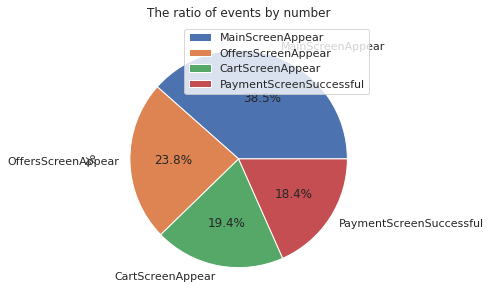

In [30]:
df_events.plot( y='%', kind = 'pie', autopct='%1.1f%%', figsize=(5, 5))
plt.title('The ratio of events by number')
plt.show()

События складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты

###  Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?
Их не нужно учитывать при расчёте воронки.

Предположительно, воронка продаж следующая:
- пользователь видит главный экран сайта
- пользователь переходит на понравившийся ему товар
- пользоватеь добавляет товар в корзину и переходит в нее
- пользователь оплачивает заказ

Дополнительно имеется событие - обучение. Возможно, пользователя учат работать с сайтом. 
Но, судя по доле этого события, оно не является обязательным на сайте. И только 4% пользователей переходят на эту страницу, поэтому она не входит в воронку продаж.

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [31]:
#Создадим столбец конверсий и рассчитаем их в цикле
df_events['conversion'] = 0
for i in range(0, len(df_events['%'])):
    if i == 0:
        df_events['conversion'].iloc[i] = 100
    else:
        df_events['conversion'].iloc[i] = round(int(df_events['device_id'].iloc[i]) / int(df_events['device_id'].iloc[i-1]), 2)*100
display(df_events)


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,device_id,%,conversion
event_name,,,
MainScreenAppear,7419,98.5,100
OffersScreenAppear,4593,61.0,62
CartScreenAppear,3734,49.6,81
PaymentScreenSuccessful,3539,47.0,95


Было подсчитано, какой процент пользователей проходит на каждый из этапов воронки, от предыдущего шага. 
- На экран с успешной оплатой переходит 95% пользователей.
- На экран с корзиной переходит 81% пользователей. 
- На экран с предложением проходит 62% пользователей, посмотревших главный экран. 

### На каком шаге теряете больше всего пользователей?

К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей. Возможно главный экран сайта не самый удобный для пользователей, или имеются другие проблемы. Наименее популярным событием в воронке продаж - событие перехода к оплате. Но если смотреть на конверсию, то большой процент пользователей теряется при переходе от главного экрана к экрану с предложением.

Можем проверить насколько главный экран сайта удобный, например, сделать опрос.

### Какая доля пользователей доходит от первого события до оплаты?

In [32]:
print(round(df_events['device_id'].iloc[3]/df_events['device_id'].iloc[0], 2)*100, '% users reach payment')

48.0 % users reach payment


До оплаты доходит 48.0 % пользователей.

## Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [33]:
# pivot table with the number of users per group
df_new_data_groups = df_new_data.pivot_table(index='experiment_id',values='device_id',aggfunc='nunique')
display(df_new_data_groups)

,device_id
experiment_id,
246,2484
247,2513
248,2537


- В 246 группе 2484 пользователя, 
- в 247 группе 2513 пользователей, 
- в группе 248, с увеличенными шрифтами, 2537 пользователей.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

### Выберем самое популярное событие. 
- Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. 
- Посчитаем долю пользователей, совершивших это событие. 
- Проверим, будет ли отличие между группами статистически достоверным. 
- Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию).
- Можно ли сказать, что разбиение на группы работает корректно?

In [34]:
# table with the number of unique users by events and control groups
df_voronka = df_new_data.pivot_table(index='experiment_id',columns='event_name', values='device_id',aggfunc='nunique')
del df_voronka['Tutorial']
df_voronka['Total'] = [df_new_data_groups['device_id'][0], df_new_data_groups['device_id'][1], df_new_data_groups['device_id'][2]]
display(df_voronka)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


Требуется сравнить в двух группах полученные доли пользователей от общего количества пользователей. Для данного сравнения используем z-тест. Чтобы провести z-тест по всем группам удобно сделать функцию, которая на вход будет принимать пять аргументов:
1. Количество пользователей, совершивших действие в 1 группе (event_1)
2. Количество пользователей, совершивших действие во 2 группе (event_2)
3. Количество пользователей всего в 1 группе (trials_1)
4. Количество пользователей всего во 2 группе (trials_2)
5. Уровень статистической значимости (alpha, по умолчанию 0.05)

In [35]:
def return_hypothesis_test (success, trials, alpha):
    
    # считаем пропорцию успеха в каждой группе
    p1 = success[0] / trials[0]
    p2 = success[1] / trials[1]
    
    # считаем пропорцию успехов в комбинированной группе
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    
    # считаем разницу
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    # задаем нормальное распределение
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

С помощью данной функции проводим сравнение долей в группах по каждому событию, в том числе и в 2 контрольных (AA-тест).

In [36]:
# сохраним количество пользователей в новых переменных
users_246 = df.query('experiment_id == 246')['device_id'].nunique()
users_247 = df.query('experiment_id == 247')['device_id'].nunique()
users_248 = df.query('experiment_id == 248')['device_id'].nunique()

In [37]:
# создаим сводную таблицу, посчитаем количество пользователей в каждой группе
users_by_group = df.pivot_table(index='event_name',
                                columns='experiment_id',
                                values='device_id',
                                aggfunc='nunique').reset_index().sort_values(by='248', ascending=False)
users_by_group

experiment_id,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Введем основную и альтернативную гипотезы для всех попарных сравнений
- Нулевая гиптеза: Доли уникальных посетителей побывавших на этапе воронки одинаковы
- Альтернративная гипотеза: Доли уникальных посетителей побывавших на этапе воронки отличаются

In [38]:
# Напишем функцию, которая на вход получает порядковый номер группы в таблице и параметр альфа, и возвращает результаты проверки гипотез
def automation (group1, group2, alpha):
    alpha_test = alpha
    count_users = ([df_voronka['Total'][group1], df_voronka['Total'][group2]])
    count_MainScreenAppear = ([df_voronka['MainScreenAppear'][group1], df_voronka['MainScreenAppear'][group2]])
    count_OffersScreenAppear = ([df_voronka['OffersScreenAppear'][group1], df_voronka['OffersScreenAppear'][group2]])
    count_CartScreenAppear = ([df_voronka['CartScreenAppear'][group1], df_voronka['CartScreenAppear'][group2]])
    count_PaymentScreenSuccessful = ([df_voronka['PaymentScreenSuccessful'][group1], df_voronka['PaymentScreenSuccessful'][group2]])
    
    print('Результаты теста по долям count_users и count_MainScreenAppear для групп')
    return_hypothesis_test(count_MainScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_OffersScreenAppear и count_users для групп')
    return_hypothesis_test(count_OffersScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_users и count_CartScreenAppear для групп')
    return_hypothesis_test(count_CartScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп')
    return_hypothesis_test(count_PaymentScreenSuccessful, count_users, alpha_test)

In [39]:
# Сделаем проверку контрольных групп А/A
automation (0, 1, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как видно из проверки гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными. Равные доли говорят о том, что контрольные группы выбраны верны.

Самым популярным событием, как и ожидалось, становится показ главного экрана сайта. С этого и начинается воронка продаж.

### Аналогично поступим с группой с изменённым шрифтом. 
- Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
- Сравним результаты с объединённой контрольной группой. 
- Какие выводы из эксперимента можно сделать?

In [40]:
#Соединим две контрольные группы в группу 249
df_voronka.loc['249'] = [df_voronka['CartScreenAppear'][0]+df_voronka['CartScreenAppear'][1] , df_voronka['MainScreenAppear'][0]+df_voronka['MainScreenAppear'][1], df_voronka['OffersScreenAppear'][0]+df_voronka['OffersScreenAppear'][1], df_voronka['PaymentScreenSuccessful'][0]+df_voronka['PaymentScreenSuccessful'][1], df_voronka['Total'][0]+df_voronka['Total'][1]]
display(df_voronka)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


In [41]:
# Сделаем проверку групп А1/B (246 и 248)
automation (0, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [42]:
print('В 246-ой контрольной группе', round(df_voronka['CartScreenAppear'].iloc[0]/df_voronka['Total'].iloc[1], 2)*100, '% пользователей переходит к оплате')
print('В 248-ой группе с измененными шрифтами', round(df_voronka['CartScreenAppear'].iloc[2]/df_voronka['Total'].iloc[2], 2)*100, '% пользователей переходит к оплате')

В 246-ой контрольной группе 50.0 % пользователей переходит к оплате
В 248-ой группе с измененными шрифтами 48.0 % пользователей переходит к оплате


In [43]:
# Сделаем проверку групп А2/B (247 и 248)
automation (1, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [44]:
# Сделаем проверку групп А/B (249 и 248)
automation (3, 2, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между первой контрольной группой (246) и группой с измененными шрифтами (248) значимых различий нет. А вот между группами 246 и 248 есть значимая разница в доле пользоватей, перешедших к странице корзины. У группы с измененными шрифтами процент перешедших к корзине 48% < 50% перешедших к корзине в контрольных группах. Значимой разницы в переходах объединенной контрольной группы с 248-ой группой нет.

### Какой уровень значимости мы выбрали при проверке статистических гипотез выше? Посчитаем, сколько проверок статистических гипотез вы сделали. 
При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. 
- Какой уровень значимости стоит применить? Если мы хотим изменить его, проделаем предыдущие пункты и проверим свои выводы.

Сделаем проверку гипотез между группами при уровне значимости 0.05

In [45]:
# Сделаем проверку групп А1/A2 (246 и 247)
automation (0, 1, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [46]:
# Сделаем проверку групп А1/B (246 и 248)
automation (0, 2, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [47]:
# Сделаем проверку групп А2/B (247 и 248)
automation (1, 2, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [48]:
# Сделаем проверку групп А/B (249 и 248)
automation (2, 3, 0.05)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При множественной проверке гипотез стоит использовать поправки к уровню значимости.
Можно использовать поправку Бонферрони, но надо учитывать что она очень сильно уменьшает уровень значимости, от чего такой уровень может достигаться очень редко, от чего повышается возможность ошибки второго рода.
Так как мы не достигли уровня 0.05, то и уровни с поправками мы достигнуть также не смогли бы.

При изменении уровня значимости на 0.05, нулевая гипотеза не отбрасывается уже ни при каких тестах. Доли во всех выборках равны. Различий между контрольными группами и тестовой нет.

## Вывод

- В датасете имеются столбцы с названием события, ID пользователя, временем события и номером экспериментальной группы. Дата записана в неправильном формате. Видны такие события: 'Появление главного экрана', 'Появление экрана оплаты' и т д. События являются частью воронки продаж на сайте. В таблице были удалены дубликаты, откорректированы типы данных, добавлен столбец с данной. Пропуски в таблице отсутствуют
- В логе есть 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения. В логе всего 7551 пользователь. В среднем на пользователя приходится 32 события, однако это число завышено из за больших выбросов. Чаще всего на пользователей приходится 1-30 событий.
- До 01.08.201 совершается очень мало событий. Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов. После удаления ранних данных были потеряно 2826 событий, что составляет около 1% от общего числа, 5 пользователей.
- По 7.7-8 тыс событий приходится на каждую эксперименальную группу. Cобытия складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты. 
- Воронка продаж следующая:
1) пользователь видит главный экран сайта
2) пользователь переходит на понравившийся ему товар
3) пользоватеь добавляет товар в корзину и переходит в нее
4) пользователь оплачивает заказ
- Дополнительно имеется событие - обучение. Возможно, пользователя учат работать с сайтом. Но, судя по доле этого события, оно не является обязательным на сайте. И только 4% пользователей переходят на эту страницу, поэтому она не входит в воронку продаж.
- Было подсчитано, какой процент пользователей проходит на каждый из этапов воронки от предыдущего шага. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей. К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей. От показа главного экрана до тоговой оплаты доходит 48 % пользователей.
- В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей. Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными. Самым популярным событием становится показ главного экрана сайта. С этого и начинается воронка продаж.
- При уровне статистической значимости 0.1, между второй контрольной группой (247) и группой с измененными шрифтами (248) значимых различий нет, так и нет разницы между тестовой группой и объединенной контрольной. А вот между группами 246 и 248 есть значимая разница в доле пользоватей, перешедших к корзине. У группы с измененными шрифтами процент перешедших к оплате 48% < 50% перешедших к оплате в первой контролной группе.
- При измепнении уровня значимости на 0.05, значимой разницы между тестовой группой и всеми контрольными группами при всех событиях нет.
- Для определения уровня значисти лучше проводить компьютерный анализ. Для альфа 0.1 контрольная группа показала себя лучше тестовой для события перехода на страницу корзины. В остальных событиях значимой разницы между группами нет. При уменьшении альфа значительной разницы между группами нет ни для каких событий.

- Можно сделать вывод, что текст на сайте менять не нужно. В лучшем случае конверсия не изменится. А доля перешедших к корзине пользователей может упасть.